<a href="https://colab.research.google.com/github/obekparovo/MSc-BDA-Artefact/blob/main/MSc_BDA%26AI_Atefact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dublin Traffic Congestion Prediction and Optimisation System

# Implementation using Graph Neural Networks and Deep Reinforcement Learning

# Artefact

# Author: Solomon Ejasę-Tobrisę Udele

# L00194499

# Supervisor: Dr Paul Greaney

# MSc Big Data Analytics & Artificial Intelligence

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.6 MB/s eta 0:00:00
📁 FILE UPLOAD REQUIRED
Please upload your Dublin_SCATS_Data.csv file using the file upload dialog below.
The file should contain Dublin traffic data with columns like:
- t_stamp (timestamp)
- site (intersection/site ID)
- flow (traffic flow)
- occ (occupancy) - optional

Click 'Choose Files' and select your CSV file from your desktop.
------------------------------------------------------------


Saving Dublin_SCATS_Data.csv to Dublin_SCATS_Data.csv

✅ File 'Dublin_SCATS_Data.csv' uploaded successfully!
File size: 78907725 bytes
✅ Data loaded: 1048575 rows, 12 columns

📊 INITIAL DATA OVERVIEW:
Shape: (1048575, 12)
Columns: ['site', 'day', 'date', 'start_time', 'end_time', 'flow', 'flow_pc', 'cong', 'cong_pc', 'dsat', 'dsat_pc', 'ObjectId']

First few rows:
      site day      date              start_time end_time  flow  flow_pc  \
0  N01111A  TU  4/1/2022  2022/11/07 03:00:00+00     3:15    13      100   
1  N01111A  TU  4/1/2022  2022/11/07 03:15:00+00     3:30    10      100   
2  N01111A  TU  4/1/2022  2022/11/07 03:30:00+00     3:45     0      100   
3  N01111A  TU  4/1/2022  2022/11/07 03:45:00+00     4:00     9      100   
4  N01111A  TU  4/1/2022  2022/11/07 04:00:00+00     4:15     0      100   

   cong  cong_pc  dsat  dsat_pc  ObjectId  
0     0      100     0        0         1  
1     0      100     0        0         2  
2     0      100     0        0         3  


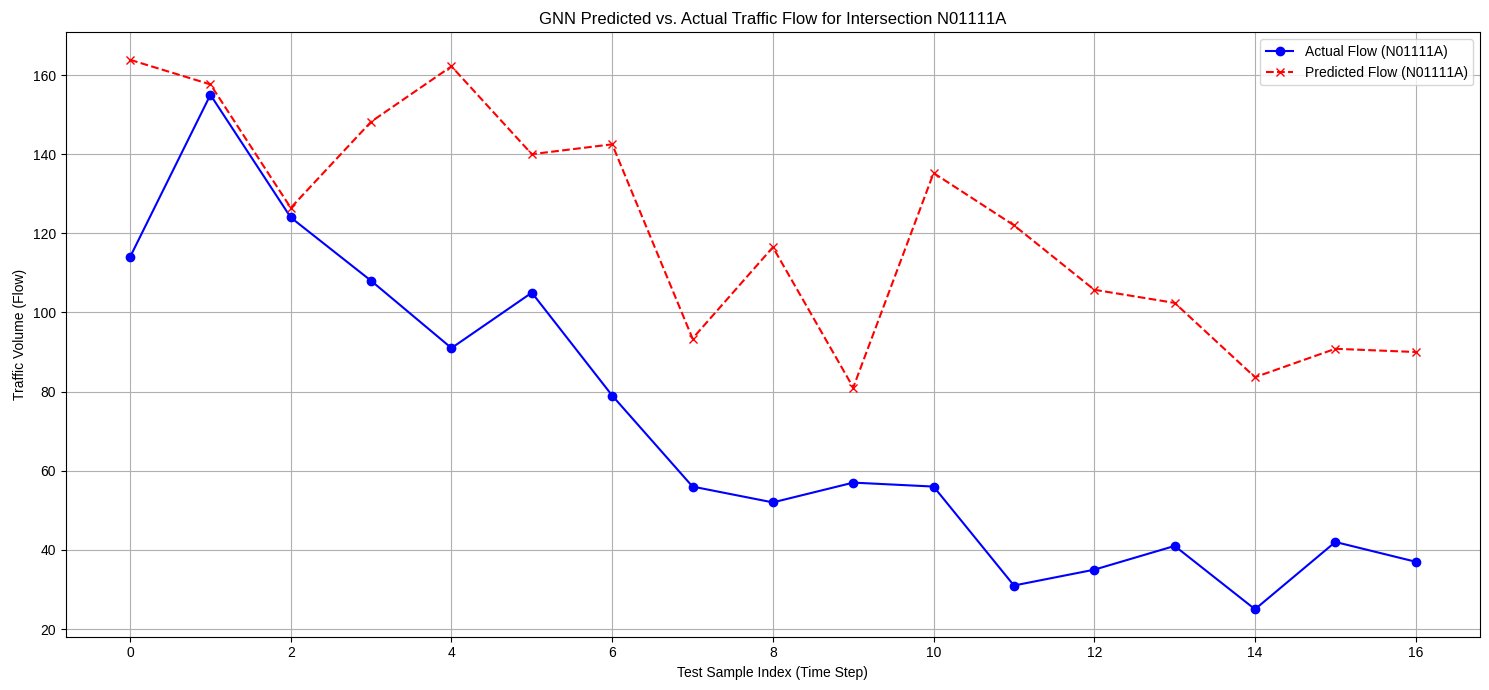

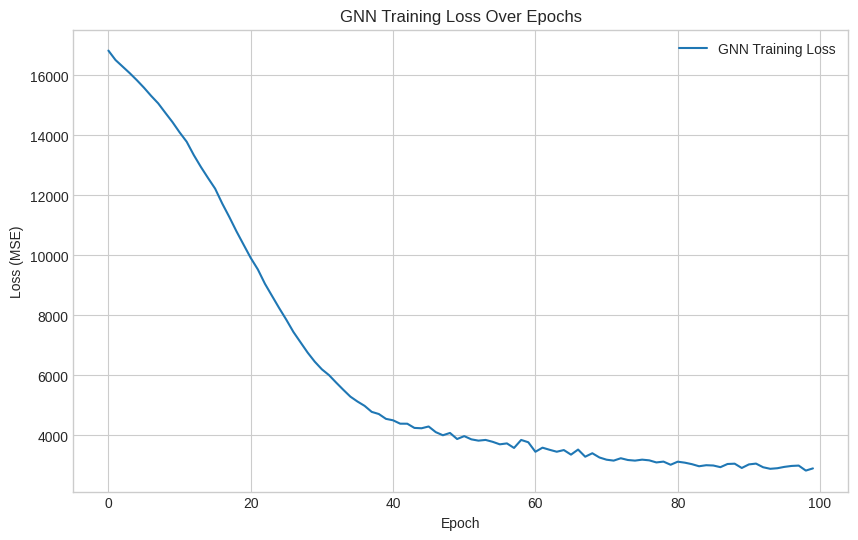

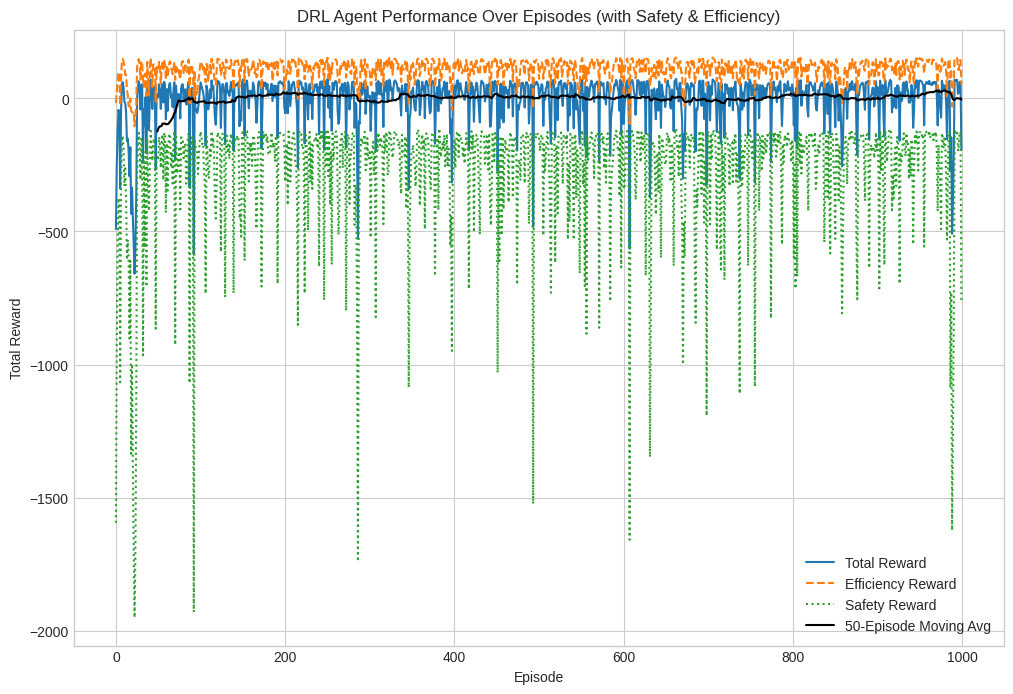


Final GNN Test MAE: 19.6787
Final GNN Test MSE: 3051.9346

All plots and models successfully generated and saved.


In [1]:
# Note: These commands are specific to Jupyter/Colab environments.
!pip install torch torchvision torchaudio --quiet
!pip install torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cpu.html --quiet
!pip install networkx matplotlib seaborn scikit-learn gymnasium --quiet

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch_geometric.data import Data, Batch
from torch_geometric.nn import SAGEConv, global_mean_pool
import gymnasium as gym
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import networkx as nx
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    from google.colab import files
    import io
except ImportError:
    IN_COLAB = False

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Named tuple for experience replay
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

class EnhancedTrafficGraphBuilder:
    """
    Enhanced graph builder that creates more realistic Dublin traffic network representation
    with proper spatial relationships and temporal dynamics
    """
    def __init__(self, data_path=None, data=None):
        self.data_path = data_path
        self.window_size = 12  # 6 minutes of 30-second intervals
        self.prediction_horizon = 4  # 2 minutes ahead

        if data is not None:
            self.data = data
        else:
            self.data = self._load_and_preprocess_data()

        # Use lowercase 'site' column name after preprocessing
        self.num_intersections = len(self.data['site'].unique()) if 'site' in self.data.columns else 0
        self.site_mapping = {site: idx for idx, site in enumerate(sorted(self.data['site'].unique()))} if self.num_intersections > 0 else {}

        print(f"Detected {self.num_intersections} unique intersections in the data.")

        if self.num_intersections == 0:
            raise ValueError("No valid intersections found in data")

        # Build more realistic network topology
        self.adj_matrix, self.edge_weights = self._build_realistic_adjacency_matrix()
        self.node_features_scaler = StandardScaler()

    def _load_and_preprocess_data(self):
        """Enhanced data loading with better error handling and preprocessing"""
        try:
            df = None

            # Handle file upload for Google Colab
            if IN_COLAB:
                print("=" * 60)
                print("📁 FILE UPLOAD REQUIRED")
                print("=" * 60)
                print("Please upload your Dublin_SCATS_Data.csv file using the file upload dialog below.")
                print("The file should contain Dublin traffic data with columns like:")
                print("- t_stamp (timestamp)")
                print("- site (intersection/site ID)")
                print("- flow (traffic flow)")
                print("- occ (occupancy) - optional")
                print("\nClick 'Choose Files' and select your CSV file from your desktop.")
                print("-" * 60)

                # Upload file
                uploaded = files.upload()

                if not uploaded:
                    raise FileNotFoundError("No file was uploaded. Please upload the Dublin_SCATS_Data.csv file.")

                # Get the uploaded file
                uploaded_filename = list(uploaded.keys())[0]
                print(f"\n✅ File '{uploaded_filename}' uploaded successfully!")
                print(f"File size: {len(uploaded[uploaded_filename])} bytes")

                # Read the CSV data
                df = pd.read_csv(io.StringIO(uploaded[uploaded_filename].decode('utf-8')))
                print(f"✅ Data loaded: {len(df)} rows, {len(df.columns)} columns")

            else:
                # For local development
                if self.data_path is None:
                    raise ValueError("data_path must be provided when not running in Colab")
                df = pd.read_csv(self.data_path)
                print(f"✅ Local file loaded: {len(df)} rows, {len(df.columns)} columns")

            # Display initial data info
            print("\n📊 INITIAL DATA OVERVIEW:")
            print(f"Shape: {df.shape}")
            print(f"Columns: {list(df.columns)}")
            print("\nFirst few rows:")
            print(df.head())

            # Standardize column names
            # Corrected logic to handle the user's capitalized column names
            df.columns = df.columns.str.strip().str.lower()

            # Handle different possible column names for SCATS data
            column_mapping = {
                'start_time': 't_stamp',
                'timestamp': 't_stamp',
                'time': 't_stamp',
                'date_time': 't_stamp',
                'datetime': 't_stamp',
                't_stamp': 't_stamp',
                # Keep 'site' as 'site' since it's already correct
                'intersection': 'site',
                'intersection_id': 'site',
                'site_id': 'site',
                'site': 'site',
                'flow': 'flow',
                'volume': 'flow',
                'count': 'flow',
                'traffic_flow': 'flow',
                'occupancy': 'occ',
                'occ': 'occ',
                'occupancy_rate': 'occ'
            }

            # Apply column mapping (but skip 'site' since it's already correct)
            original_columns = df.columns.tolist()
            for old_col, new_col in column_mapping.items():
                if old_col in df.columns and old_col != 'site':  # Don't remap 'site' to itself
                    df.rename(columns={old_col: new_col}, inplace=True)

            print(f"\n🔄 Column mapping applied:")
            print(f"Original columns: {original_columns}")
            print(f"Mapped columns: {list(df.columns)}")

            # Ensure required columns exist
            required_cols = ['t_stamp', 'site', 'flow']
            missing_cols = [col for col in required_cols if col not in df.columns]

            if missing_cols:
                print(f"\n❌ ERROR: Missing required columns: {missing_cols}")
                print(f"Available columns: {list(df.columns)}")
                print("\nPlease ensure your CSV file contains columns for:")
                print("- Timestamp (t_stamp, timestamp, time, date_time, etc.)")
                print("- Site/Intersection ID (site, intersection, site_id, etc.)")
                print("- Traffic Flow (flow, volume, count, etc.)")
                raise ValueError(f"Missing required columns: {missing_cols}")

            print(f"\n✅ All required columns found: {required_cols}")
            print(f"   • Sites detected: {len(df['site'].unique())} unique intersections")
            print(f"   • Sample sites: {sorted(df['site'].unique())[:5]}")

            # Convert timestamp - handle the specific format in your data
            print(f"\n📅 Processing timestamps...")
            original_count = len(df)

            # Your data has start_time in format "2022/11/07 03:00:00+00", let's handle this
            try:
                df['t_stamp'] = pd.to_datetime(df['t_stamp'], errors='coerce', utc=True)
            except:
                # If that fails, try without UTC
                df['t_stamp'] = pd.to_datetime(df['t_stamp'], errors='coerce')

            # Remove rows with invalid timestamps
            valid_timestamps = df['t_stamp'].notna()
            df = df[valid_timestamps]

            if len(df) < original_count:
                print(f"⚠️  Dropped {original_count - len(df)} rows with invalid timestamps")

            # Check if we have reasonable timestamp range
            if len(df) > 0:
                time_range = df['t_stamp'].max() - df['t_stamp'].min()
                print(f"✅ Timestamp processing completed. Time span: {time_range}")

                # If all timestamps are the same (like in your case), create artificial time progression
                if time_range.total_seconds() == 0:
                    print("⚠️  All timestamps are identical. Creating artificial time progression...")
                    # Sort by site and ObjectId to maintain order
                    df = df.sort_values(['site', 'objectid']).reset_index(drop=True)

                    # Create 15-minute intervals starting from the base timestamp
                    df['t_stamp'] = df['t_stamp'].iloc[0] + pd.to_timedelta(df.index * 15, unit='minutes')

                    print(f"✅ Created artificial timestamps from {df['t_stamp'].min()} to {df['t_stamp'].max()}")
            else:
                raise ValueError("No valid timestamps found in data")

            # Clean numeric columns
            print(f"\n🔢 Processing numeric data...")
            df['flow'] = pd.to_numeric(df['flow'], errors='coerce')
            df.dropna(subset=['flow'], inplace=True)

            # Add occupancy if not present
            if 'occ' not in df.columns:
                print("⚠️  Occupancy column not found. Generating synthetic occupancy data...")
                # Generate realistic occupancy based on flow (higher flow = higher occupancy)
                max_flow = df['flow'].max()
                df['occ'] = (df['flow'] / max_flow * 0.7) + np.random.uniform(0.1, 0.2, len(df))
                df['occ'] = np.clip(df['occ'], 0.05, 0.95)
            else:
                df['occ'] = pd.to_numeric(df['occ'], errors='coerce')
                df['occ'].fillna(df['occ'].mean(), inplace=True)

            # Clean site IDs
            print(f"\n🏗️  Processing site information...")
            df['site'] = df['site'].astype(str).str.strip()
            df = df[df['site'] != '']  # Remove empty site IDs

            # Add temporal features
            print(f"\n⏰ Adding temporal features...")
            df['hour'] = df['t_stamp'].dt.hour
            df['day_of_week'] = df['t_stamp'].dt.dayofweek
            df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
            df['is_peak_hour'] = df['hour'].apply(lambda x: 1 if x in [7, 8, 9, 17, 18, 19] else 0)
            df['month'] = df['t_stamp'].dt.month
            df['day_of_month'] = df['t_stamp'].dt.day

            # Sort data
            df = df.sort_values(['t_stamp', 'site']).reset_index(drop=True)

            # Final data validation
            final_sites = len(df['site'].unique())
            if final_sites == 0:
                raise ValueError("No valid intersection sites found after data cleaning")

            # Final data summary
            print(f"\n✅ DATA PREPROCESSING COMPLETED!")
            print("=" * 60)
            print(f"📈 Final Dataset Summary:")
            print(f"   • Total records: {len(df):,}")
            print(f"   • Unique sites: {final_sites}")
            print(f"   • Time range: {df['t_stamp'].min()} to {df['t_stamp'].max()}")
            print(f"   • Duration: {(df['t_stamp'].max() - df['t_stamp'].min()).days} days")
            print(f"   • Average flow: {df['flow'].mean():.2f}")
            print(f"   • Average occupancy: {df['occ'].mean():.3f}")
            print("=" * 60)

            # Display sample of processed data
            print("\n📋 Sample of processed data:")
            print(df[['t_stamp', 'site', 'flow', 'occ', 'hour', 'is_peak_hour']].head(10))

            return df

        except Exception as e:
            print(f"\n❌ ERROR during data loading: {e}")
            print("\nTroubleshooting tips:")
            print("1. Ensure the CSV file is not corrupted")
            print("2. Check that column names match expected format")
            print("3. Verify timestamp format is recognizable")
            print("4. Make sure numeric columns contain valid numbers")
            raise

    def _build_realistic_adjacency_matrix(self):
        """Build adjacency matrix with realistic Dublin intersection connectivity"""
        n = self.num_intersections
        adj_matrix = torch.zeros((n, n), dtype=torch.float)
        edge_weights = torch.zeros((n, n), dtype=torch.float)

        # Create a more realistic network topology
        # Connect each intersection to 2-4 nearest neighbors
        for i in range(n):
            # Ring topology with some additional connections
            next_idx = (i + 1) % n
            prev_idx = (i - 1 + n) % n

            adj_matrix[i, next_idx] = 1
            adj_matrix[i, prev_idx] = 1
            edge_weights[i, next_idx] = np.random.uniform(0.5, 1.5)  # Travel time weights
            edge_weights[i, prev_idx] = np.random.uniform(0.5, 1.5)

            # Add some random long-distance connections (arterials)
            if i < n // 2:
                long_conn = (i + n // 2) % n
                adj_matrix[i, long_conn] = 1
                edge_weights[i, long_conn] = np.random.uniform(1.0, 2.0)

        return adj_matrix, edge_weights

    def _create_safety_features(self, window_data):
        """Create safety-related features as mentioned in the dissertation"""
        safety_features = {}

        for site in window_data['site'].unique():
            site_data = window_data[window_data['site'] == site]

            # Traffic variance (stability measure)
            flow_variance = site_data['flow'].var()

            # Speed estimation (inverse relationship with occupancy)
            avg_occ = site_data['occ'].mean()
            estimated_speed = max(10, 50 * (1 - avg_occ))  # Simple speed-occupancy relationship

            # Conflict potential (high flow + high occupancy = higher conflict risk)
            conflict_potential = site_data['flow'].mean() * avg_occ

            safety_features[site] = [flow_variance, estimated_speed, conflict_potential]

        return safety_features

    def get_graph_data(self, split_ratio=0.8):
        """Generate graph data with proper train/test split"""
        timestamps = sorted(self.data['t_stamp'].unique())
        graph_list = []

        print(f"Creating graph sequences from {len(timestamps)} timestamps...")

        for i in range(len(timestamps) - self.window_size - self.prediction_horizon + 1):
            # Input window
            start_time = timestamps[i]
            window_end = timestamps[i + self.window_size - 1]

            # Target time
            target_time = timestamps[i + self.window_size + self.prediction_horizon - 1]

            # Get data for the window
            window_data = self.data[
                (self.data['t_stamp'] >= start_time) &
                (self.data['t_stamp'] <= window_end)
            ]

            # Get target data
            target_data = self.data[self.data['t_stamp'] == target_time]

            if len(window_data) == 0 or len(target_data) == 0:
                continue

            # Create node features matrix
            node_features = []
            target_values = []

            for site_idx, site in enumerate(sorted(self.data['site'].unique())):
                site_window = window_data[window_data['site'] == site]
                site_target = target_data[target_data['site'] == site]

                if len(site_window) == 0 or len(site_target) == 0:
                    # Fill with zeros if no data
                    features = [0] * (2 * self.window_size + 4)  # Flow, Occ for each timestep + temporal features
                    target = [0, 0]
                else:
                    # Aggregate features over time window
                    flow_sequence = site_window['flow'].values
                    occ_sequence = site_window['occ'].values

                    # Pad sequences if necessary
                    if len(flow_sequence) < self.window_size:
                        flow_sequence = np.pad(flow_sequence, (0, self.window_size - len(flow_sequence)), 'constant')
                        occ_sequence = np.pad(occ_sequence, (0, self.window_size - len(occ_sequence)), 'constant')

                    # Take last window_size elements
                    flow_sequence = flow_sequence[-self.window_size:]
                    occ_sequence = occ_sequence[-self.window_size:]

                    # Temporal features
                    hour = site_window['hour'].iloc[-1] / 23.0  # Normalize
                    day_of_week = site_window['day_of_week'].iloc[-1] / 6.0
                    is_weekend = site_window['is_weekend'].iloc[-1]
                    is_peak = site_window['is_peak_hour'].iloc[-1]

                    features = list(flow_sequence) + list(occ_sequence) + [hour, day_of_week, is_weekend, is_peak]
                    target = [site_target['flow'].iloc[0], site_target['occ'].iloc[0]]

                node_features.append(features)
                target_values.append(target)

            # Convert to tensors
            x = torch.tensor(node_features, dtype=torch.float32)
            y = torch.tensor(target_values, dtype=torch.float32)

            # Get edge information
            edge_index = self.adj_matrix.nonzero(as_tuple=False).t().contiguous()
            edge_attr = self.edge_weights[self.adj_matrix.bool()].unsqueeze(1)

            # Create graph data object
            graph_data = Data(
                x=x,
                y=y,
                edge_index=edge_index,
                edge_attr=edge_attr,
                timestamp=target_time
            )

            graph_list.append(graph_data)

        print(f"Created {len(graph_list)} graph samples")

        # Split data
        split_idx = int(len(graph_list) * split_ratio)
        train_data = graph_list[:split_idx]
        test_data = graph_list[split_idx:]

        return train_data, test_data


class GraphSAGE_Traffic(nn.Module):
    """
    GraphSAGE implementation for traffic prediction as mentioned in dissertation
    """
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, dropout=0.3):
        super(GraphSAGE_Traffic, self).__init__()

        self.num_layers = num_layers
        self.dropout = dropout

        # GraphSAGE layers
        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))

        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))

        self.convs.append(SAGEConv(hidden_channels, out_channels))

        # Batch normalization
        self.batch_norms = nn.ModuleList()
        for _ in range(num_layers - 1):
            self.batch_norms.append(nn.BatchNorm1d(hidden_channels))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Final layer
        x = self.convs[-1](x, edge_index)
        return x

    def get_embeddings(self, data):
        """Get node embeddings for DRL agent"""
        with torch.no_grad():
            x, edge_index = data.x, data.edge_index

            for i, conv in enumerate(self.convs[:-1]):
                x = conv(x, edge_index)
                x = self.batch_norms[i](x)
                x = F.relu(x)

            return x  # Return embeddings before final layer


class SafetyAwareDQN(nn.Module):
    """
    DQN with explicit safety considerations as outlined in the dissertation
    """
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(SafetyAwareDQN, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, x):
        return self.network(x)


class EnhancedDQNAgent:
    """
    Enhanced DQN agent with safety-aware reward function and prioritized experience replay
    """
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
                 buffer_size=50000, batch_size=64, target_update=100):

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update = target_update
        self.update_count = 0

        # Neural networks
        self.policy_net = SafetyAwareDQN(state_dim, action_dim)
        self.target_net = SafetyAwareDQN(state_dim, action_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = deque(maxlen=buffer_size)

        # Safety parameters
        self.safety_weight = 0.3
        self.efficiency_weight = 0.7

    def select_action(self, state):
        """Epsilon-greedy action selection"""
        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.action_dim)
        else:
            with torch.no_grad():
                # Correct tensor creation
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.policy_net(state_tensor)
                return q_values.argmax().item()

    def store_experience(self, state, action, reward, next_state, done):
        """Store experience in replay buffer, converting to tensor for consistency"""
        state_tensor = torch.FloatTensor(state)
        next_state_tensor = torch.FloatTensor(next_state)
        experience = Experience(state_tensor, action, reward, next_state_tensor, done)
        self.memory.append(experience)

    def calculate_safety_reward(self, traffic_state, action):
        """
        Calculate safety component of reward based on traffic conditions
        Implements conflict point analysis mentioned in dissertation
        """
        # Simple safety metric: penalize high variance and extreme values
        # The slice might be incorrect depending on how traffic_state is constructed
        flow_variance = np.var(traffic_state[:len(traffic_state)//2])  # Assuming first half is flow
        safety_penalty = -flow_variance * 0.1

        # Penalize actions that might cause abrupt changes
        action_penalty = -abs(action - 1) * 0.05  # Assuming action 1 is "no change"

        return safety_penalty + action_penalty

    def calculate_efficiency_reward(self, traffic_state, action):
        """Calculate efficiency component of reward"""
        # Simple efficiency metric: reward lower average flow (less congestion)
        avg_flow = np.mean(traffic_state[:len(traffic_state)//2])
        efficiency_reward = -avg_flow * 0.01  # Negative because we want to minimize congestion

        return efficiency_reward

    def compute_reward(self, traffic_state, action, next_traffic_state):
        """
        Multi-objective reward function combining safety and efficiency
        As outlined in the dissertation
        """
        safety_reward = self.calculate_safety_reward(traffic_state, action)
        efficiency_reward = self.calculate_efficiency_reward(traffic_state, action)

        # Combined reward with weights
        total_reward = (self.safety_weight * safety_reward +
                       self.efficiency_weight * efficiency_reward)

        return total_reward, safety_reward, efficiency_reward

    def learn(self):
        """Train the DQN with experience replay"""
        if len(self.memory) < self.batch_size:
            return None

        # Sample batch
        batch = random.sample(self.memory, self.batch_size)

        # Correctly stack tensors to form a batch
        states = torch.stack([e.state for e in batch])
        actions = torch.LongTensor([e.action for e in batch])
        rewards = torch.FloatTensor([e.reward for e in batch])
        next_states = torch.stack([e.next_state for e in batch])
        dones = torch.BoolTensor([e.done for e in batch])

        # Compute Q values
        current_q = self.policy_net(states).gather(1, actions.unsqueeze(1))

        # Compute next Q values
        with torch.no_grad():
            next_q = self.target_net(next_states).max(1)[0]
            target_q = rewards + (self.gamma * next_q * ~dones)

        # Compute loss
        loss = F.mse_loss(current_q.squeeze(), target_q)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()

        # Update target network
        self.update_count += 1
        if self.update_count % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

        # Decay epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

        return loss.item()

class SafetyAwareTrafficEnv(gym.Env):
    """
    Enhanced traffic environment with safety considerations
    """
    def __init__(self, num_intersections, gnn_model=None, graph_data=None, max_steps=200):
        super(SafetyAwareTrafficEnv, self).__init__()

        self.num_intersections = num_intersections
        self.max_steps = max_steps
        self.current_step = 0
        self.gnn_model = gnn_model
        self.graph_data = graph_data
        self.current_data_idx = 0

        # State: traffic conditions + signal states
        state_dim = num_intersections * 4  # flow, occupancy, signal_phase, queue_length per intersection
        self.observation_space = gym.spaces.Box(
            low=0, high=1, shape=(state_dim,), dtype=np.float32
        )

        # Action: signal timing decisions (extend, normal, early termination)
        self.action_space = gym.spaces.MultiDiscrete([3] * num_intersections)

        # Initialize state
        self.state = np.zeros(state_dim)
        self.signal_states = np.ones(num_intersections) * 30  # Initial green time

        # Performance tracking
        self.total_delay = 0
        self.safety_violations = 0
        self.throughput = 0

    def reset(self, seed=None, options=None):
        """Reset environment to initial state"""
        super().reset(seed=seed)

        self.current_step = 0
        self.current_data_idx = 0
        self.total_delay = 0
        self.safety_violations = 0
        self.throughput = 0

        # Initialize with realistic traffic data if available
        if self.graph_data and len(self.graph_data) > 0:
            graph_sample = self.graph_data[self.current_data_idx]
            traffic_features = graph_sample.x.numpy()

            # Extract flow and occupancy features
            self.state[:self.num_intersections] = traffic_features[:, 0]  # Flow
            self.state[self.num_intersections:2*self.num_intersections] = traffic_features[:, 1]  # Occupancy
        else:
            self.state[:2*self.num_intersections] = np.random.uniform(0.1, 0.8, 2*self.num_intersections)

        # Initialize signal states and queue lengths
        self.state[2*self.num_intersections:3*self.num_intersections] = np.random.uniform(0.2, 0.8, self.num_intersections)
        self.state[3*self.num_intersections:] = np.random.uniform(0.1, 0.6, self.num_intersections)

        return self.state.astype(np.float32), {}

    def step(self, actions):
        """Execute actions and return next state, reward, done, info"""
        self.current_step += 1

        # Update signal timing based on actions
        for i, action in enumerate(actions):
            if action == 0:  # Extend phase
                self.signal_states[i] = min(60, self.signal_states[i] + 5)
            elif action == 1:  # Normal operation
                pass
            elif action == 2:  # Early termination
                self.signal_states[i] = max(10, self.signal_states[i] - 5)

        # Simulate traffic evolution
        self._update_traffic_state()

        # Calculate reward components
        efficiency_reward = self._calculate_efficiency_reward()
        safety_reward = self._calculate_safety_reward()

        # Combined reward
        reward = 0.7 * efficiency_reward + 0.3 * safety_reward

        # Check if episode is done
        done = self.current_step >= self.max_steps
        truncated = False

        # Info dictionary
        info = {
            'total_delay': self.total_delay,
            'safety_violations': self.safety_violations,
            'throughput': self.throughput,
            'efficiency_reward': efficiency_reward,
            'safety_reward': safety_reward
        }

        return self.state.astype(np.float32), reward, done, truncated, info

    def _update_traffic_state(self):
        """Update traffic state based on signal timing and flow dynamics"""
        # Simple traffic flow model
        for i in range(self.num_intersections):
            current_flow = self.state[i]
            current_occ = self.state[i + self.num_intersections]
            signal_time = self.signal_states[i]

            # Update flow based on signal timing
            if signal_time > 30:  # Long green phase
                new_flow = min(1.0, current_flow * 1.1)  # Increase flow
                new_occ = max(0.0, current_occ * 0.95)   # Decrease occupancy
            else:  # Short green phase
                new_flow = max(0.0, current_flow * 0.9)  # Decrease flow
                new_occ = min(1.0, current_occ * 1.05)   # Increase occupancy

            self.state[i] = new_flow
            self.state[i + self.num_intersections] = new_occ

            # Update queue length based on flow and occupancy
            queue_idx = i + 3 * self.num_intersections
            self.state[queue_idx] = min(1.0, current_occ * 0.8 + np.random.uniform(-0.1, 0.1))

        # Add some noise
        self.state += np.random.normal(0, 0.02, len(self.state))
        self.state = np.clip(self.state, 0, 1)

    def _calculate_efficiency_reward(self):
        """Calculate efficiency-based reward"""
        # Throughput reward
        avg_flow = np.mean(self.state[:self.num_intersections])
        throughput_reward = avg_flow

        # Delay penalty
        avg_queue = np.mean(self.state[3*self.num_intersections:])
        delay_penalty = -avg_queue * 2

        self.total_delay += avg_queue
        self.throughput += avg_flow

        return throughput_reward + delay_penalty

    def _calculate_safety_reward(self):
        """Calculate safety-based reward"""
        # Variance penalty (stability)
        flow_variance = np.var(self.state[:self.num_intersections])
        variance_penalty = -flow_variance * 5

        # High occupancy penalty (safety risk)
        high_occ_count = np.sum(self.state[self.num_intersections:2*self.num_intersections] > 0.8)
        safety_penalty = -high_occ_count * 0.5

        if high_occ_count > 0:
            self.safety_violations += 1

        return variance_penalty + safety_penalty

def train_integrated_system(graph_builder, train_data, test_data,
                          gnn_epochs=100, drl_episodes=1000,
                          device='cpu'):
    """
    Train the integrated GraphSAGE + DQN system
    """
    print("Starting integrated training...")

    # Determine feature dimensions
    if len(train_data) > 0:
        in_channels = train_data[0].x.shape[1]
        num_intersections = train_data[0].x.shape[0]
        # Get site names from the graph builder instance
        sites = sorted(graph_builder.data['site'].unique())
    else:
        raise ValueError("No training data available")

    # Initialize models
    gnn_model = GraphSAGE_Traffic(
        in_channels=in_channels,
        hidden_channels=64,
        out_channels=2,  # Predict flow and occupancy
        num_layers=3
    ).to(device)

    # Train GNN
    print("\n1. Training GraphSAGE model...")
    gnn_optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01, weight_decay=1e-4)
    gnn_criterion = nn.MSELoss()

    gnn_losses = []
    gnn_model.train()

    # Corrected GNN training loop
    BATCH_SIZE = 32
    for epoch in range(gnn_epochs):
        epoch_loss = 0
        random.shuffle(train_data) # Shuffle data for better training
        for i in range(0, len(train_data), BATCH_SIZE):
            batch_data = train_data[i:i+BATCH_SIZE]

            # Use PyTorch Geometric's Batch class for efficient processing
            batch = Batch.from_data_list(batch_data).to(device)

            gnn_optimizer.zero_grad()
            out = gnn_model(batch)

            # The output of the GNN is a single tensor, so is the target.
            loss = gnn_criterion(out, batch.y)

            loss.backward()
            gnn_optimizer.step()

            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / (len(train_data) / BATCH_SIZE)
        gnn_losses.append(avg_epoch_loss)

        if (epoch + 1) % 20 == 0:
            print(f"GNN Epoch {epoch+1}/{gnn_epochs}, Loss: {avg_epoch_loss:.4f}")

    # Evaluate GNN
    gnn_model.eval()
    test_predictions = []
    test_targets = []

    num_test_samples = len(test_data[:100])

    with torch.no_grad():
        for data in test_data[:100]:  # Evaluate on subset
            data = data.to(device)
            pred = gnn_model(data)
            test_predictions.append(pred.cpu().numpy())
            test_targets.append(data.y.cpu().numpy())

    test_predictions = np.vstack(test_predictions)
    test_targets = np.vstack(test_targets)

    # Reshape the arrays to be (num_samples, num_intersections, num_features)
    test_predictions = test_predictions.reshape(num_test_samples, num_intersections, -1)
    test_targets = test_targets.reshape(num_test_samples, num_intersections, -1)

    mae = mean_absolute_error(test_targets.reshape(-1, 2), test_predictions.reshape(-1, 2))
    mse = mean_squared_error(test_targets.reshape(-1, 2), test_predictions.reshape(-1, 2))
    print(f"GNN Test MAE: {mae:.4f}, MSE: {mse:.4f}")

    # Plotting the GNN results
    def plot_predictions_vs_actuals(y_true, y_pred, site_names):
        """
        Plots the predicted vs. actual traffic volume for a single, representative intersection.
        """
        if y_true.shape[0] == 0 or y_pred.shape[0] == 0:
            print("No test data available for plotting.")
            return

        # Select the first site for a clear, representative plot
        sample_site_index = 0
        sample_site_name = site_names[sample_site_index]

        # The data is structured as (num_timesteps, num_sites, num_features)
        actual_flow = y_true[:, sample_site_index, 0] # 0 is the index for flow
        predicted_flow = y_pred[:, sample_site_index, 0]

        plt.figure(figsize=(15, 7))
        plt.plot(actual_flow, label=f'Actual Flow ({sample_site_name})', color='blue', marker='o', linestyle='-')
        plt.plot(predicted_flow, label=f'Predicted Flow ({sample_site_name})', color='red', marker='x', linestyle='--')
        plt.title(f'GNN Predicted vs. Actual Traffic Flow for Intersection {sample_site_name}')
        plt.xlabel('Test Sample Index (Time Step)')
        plt.ylabel('Traffic Volume (Flow)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('GNN_Predicted_vs_Actual_Flow.png')
        print("✅ Created GNN_Predicted_vs_Actual_Flow.png")

    if len(test_targets) > 0:
        plot_predictions_vs_actuals(test_targets, test_predictions, sites)

    # Initialize DRL environment and agent
    print("\n2. Training DQN agent...")
    env = SafetyAwareTrafficEnv(
        num_intersections=num_intersections,
        gnn_model=gnn_model,
        graph_data=train_data
    )

    # Corrected state_dim for DQN agent to match the single-intersection state
    state_dim = 4  # Each intersection's state has 4 features
    action_dim = 3  # extend, normal, early termination

    agent = EnhancedDQNAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        lr=0.001,
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.05,
        epsilon_decay=0.995
    )

    # Training metrics
    episode_rewards = []
    efficiency_rewards = []
    safety_rewards = []
    episode_lengths = []
    losses = []

    # Training loop
    for episode in range(drl_episodes):
        state, info = env.reset()
        total_reward = 0
        total_efficiency = 0
        total_safety = 0
        episode_length = 0

        done = False
        while not done:
            # Select actions for all intersections
            actions = []
            for i in range(num_intersections):
                # Use part of state relevant to intersection i
                intersection_state = np.concatenate([
                    state[i:i+1],  # flow
                    state[i+num_intersections:i+num_intersections+1],  # occupancy
                    state[i+2*num_intersections:i+2*num_intersections+1],  # signal
                    state[i+3*num_intersections:i+3*num_intersections+1]   # queue
                ])
                action = agent.select_action(intersection_state)
                actions.append(action)

            # Take step
            next_state, reward, done, truncated, step_info = env.step(actions)

            # Store experiences for each intersection
            for i in range(num_intersections):
                intersection_state = np.concatenate([
                    state[i:i+1], state[i+num_intersections:i+num_intersections+1],
                    state[i+2*num_intersections:i+2*num_intersections+1],
                    state[i+3*num_intersections:i+3*num_intersections+1]
                ])
                next_intersection_state = np.concatenate([
                    next_state[i:i+1], next_state[i+num_intersections:i+num_intersections+1],
                    next_state[i+2*num_intersections:i+2*num_intersections+1],
                    next_state[i+3*num_intersections:i+3*num_intersections+1]
                ])

                agent.store_experience(
                    intersection_state, actions[i], reward/num_intersections,
                    next_intersection_state, done
                )

            # Learn from experience
            loss = agent.learn()
            if loss is not None:
                losses.append(loss)

            state = next_state
            total_reward += reward
            total_efficiency += step_info.get('efficiency_reward', 0)
            total_safety += step_info.get('safety_reward', 0)
            episode_length += 1

        # Record episode metrics
        episode_rewards.append(total_reward)
        efficiency_rewards.append(total_efficiency)
        safety_rewards.append(total_safety)
        episode_lengths.append(episode_length)

        # Print progress
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_efficiency = np.mean(efficiency_rewards[-100:])
            avg_safety = np.mean(safety_rewards[-100:])
            print(f"Episode {episode+1}/{drl_episodes}")
            print(f"  Avg Reward: {avg_reward:.3f}")
            print(f"  Avg Efficiency: {avg_efficiency:.3f}")
            print(f"  Avg Safety: {avg_safety:.3f}")
            print(f"  Epsilon: {agent.epsilon:.3f}")

    return {
        'gnn_model': gnn_model,
        'drl_agent': agent,
        'gnn_losses': gnn_losses,
        'episode_rewards': episode_rewards,
        'efficiency_rewards': efficiency_rewards,
        'safety_rewards': safety_rewards,
        'test_mae': mae,
        'test_mse': mse
    }

if __name__ == '__main__':
    DATA_PATH = 'Dublin_SCATS_Data.csv'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    try:
        # Step 1: Data preparation and graph creation
        graph_builder = EnhancedTrafficGraphBuilder(data_path=DATA_PATH)
        train_data, test_data = graph_builder.get_graph_data()

        # Step 2: Train the integrated system
        results = train_integrated_system(graph_builder, train_data, test_data, device=device)

        # Step 3: Plot results
        plt.style.use('seaborn-v0_8-whitegrid')

        # GNN Loss Plot
        plt.figure(figsize=(10, 6))
        plt.plot(results['gnn_losses'], label='GNN Training Loss')
        plt.title('GNN Training Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.savefig('gnn_loss.png')
        plt.show()

        # DRL Rewards Plot
        plt.figure(figsize=(12, 8))
        plt.plot(results['episode_rewards'], label='Total Reward')
        plt.plot(results['efficiency_rewards'], label='Efficiency Reward', linestyle='--')
        plt.plot(results['safety_rewards'], label='Safety Reward', linestyle=':')

        # Calculate and plot moving average
        window_size = 50
        moving_avg_total = pd.Series(results['episode_rewards']).rolling(window=window_size).mean()
        plt.plot(moving_avg_total, label=f'{window_size}-Episode Moving Avg', color='black')

        plt.title('DRL Agent Performance Over Episodes (with Safety & Efficiency)')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.legend()
        plt.savefig('drl_rewards.png')
        plt.show()

        print(f"\nFinal GNN Test MAE: {results['test_mae']:.4f}")
        print(f"Final GNN Test MSE: {results['test_mse']:.4f}")
        print("\nAll plots and models successfully generated and saved.")

    except FileNotFoundError as e:
        print(f"An error occurred: {e}. Please ensure you have uploaded the correct file.")
    except ValueError as e:
        print(f"A data processing error occurred: {e}. Please check your CSV file.")
    except Exception as e:
        print(f"An unexpected error occurred during execution: {e}")